In [529]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow import keras

## Loading MNIST with Tensorflow

In [530]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [531]:
y_train[0]

5

In [532]:
x_crop_train = []
y_crop_train = []

for x, y in zip(x_train, y_train):
    if y == 6 or y == 5:
        x_crop_train.append(x)
        y_crop_train.append(y)

x_crop_test = []
y_crop_test = []

for x, y in zip(x_test, y_test):
    if y == 6 or y == 5:
        x_crop_test.append(x)
        y_crop_test.append(y)

assert(len(x_crop_train) == len(y_crop_train))
assert(len(x_crop_test) == len(y_crop_test))

In [533]:
del x_train
del y_train
del x_test
del y_test

In [534]:
y_crop_train = [1 if x == 5 else 0 for x in y_crop_train ]
y_crop_test = [1 if x == 5 else 0 for x in y_crop_test ]

## Reading the image pixel by pixel

In [535]:
first_image = x_crop_train[0]

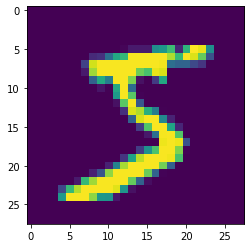

In [536]:
plt.imshow(first_image)

In [537]:
first_image[8][10]

253

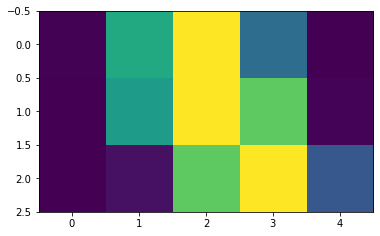

In [538]:
plt.imshow([item[10:15] for item in first_image[10:13]])

In [539]:
[item[10:15] for item in first_image[10:13]]

[array([  1, 154, 253,  90,   0], dtype=uint8),
 array([  0, 139, 253, 190,   2], dtype=uint8),
 array([  0,  11, 190, 253,  70], dtype=uint8)]

In [540]:
# just need to work with the indexes
first_image[10][11]

154

### Creating an array for each pixel 
We have images 28x28, so we will have 784 arrays of the size of the mnist dataset

In [541]:
# 28
img_size = len(x_crop_train[0])
# 784
number_pixels = len(x_crop_train[0])*len(x_crop_train[0][0])


len_train = len(x_crop_train)
len_test = len(x_crop_test)

In [542]:

def get_pixels(dataset):
    ## will store the arrays for each pixel
    _arrays_pixels = []
    for pixel in range(number_pixels):
        _arrays_pixels.append( list() )

    for image in dataset:
        for pixel in range(0,number_pixels):
            idx_column = int(pixel%img_size)
            idx_row = int(pixel/img_size)
            
            _arrays_pixels[pixel].append(image[idx_row][idx_column])

    return _arrays_pixels


arrays_pixels = get_pixels(x_crop_train)

'''
The resulting array works as following:
[
    [] -> pixel 0x0 of every image in the train dataset
    [] -> pixel 0x1 of every image in the train dataset
    ...
    [] -> pixel 28x28 of every image in the dataset
]

The ideia is that each of this array of every pixel will be used as the x input of a classifier alongside y_crop_train
'''

'\nThe resulting array works as following:\n[\n    [] -> pixel 0x0 of every image in the train dataset\n    [] -> pixel 0x1 of every image in the train dataset\n    ...\n    [] -> pixel 28x28 of every image in the dataset\n]\n\nThe ideia is that each of this array of every pixel will be used as the x input of a classifier alongside y_crop_train\n'

In [543]:
x_crop_train[0][8][10]

253

In [544]:
arrays_pixels[8*28+10][0]

253

In [545]:
assert(len(arrays_pixels) == number_pixels)
assert(len(arrays_pixels[0]) == len_train)
assert(len(arrays_pixels[0]) == len(y_crop_train))

# checking if the data was stored correctly
assert(arrays_pixels[8*28 + 10][0] == x_crop_train[0][8][10])

## Training Classifiers

For the weak classifiers, I chose a Decision Tree. Since the input is a single value, there is no need for a more complex classifier. A regression model would also work.

In [546]:
from sklearn import tree

In [547]:
# needed since this is a single feature input
arrays_pixels = [np.array(lst).reshape(-1, 1) for lst in arrays_pixels]
# need to convert to numpy
y_crop_train = np.array(y_crop_train).reshape(-1, 1)

In [548]:
weak_classifiers = []

for X_input in arrays_pixels:
    weak_clf = tree.DecisionTreeClassifier()
    weak_clf = weak_clf.fit(X_input, y_crop_train)
    weak_classifiers.append(weak_clf)

In [549]:
assert (len(weak_classifiers) == number_pixels)

### Testing weak classifiers

In [550]:
from sklearn.metrics import accuracy_score

In [551]:
scores = []
training_preds = []

# gets each classifier trained at each pixel and predicts in the training dataset how well it was
for pixel in range(0, number_pixels):
    clf = weak_classifiers[pixel]

    preds = clf.predict(arrays_pixels[pixel])
    training_preds.append(preds)
    score = accuracy_score(preds, y_crop_train)
    scores.append(score)

In [552]:
arrays_pixels_test = get_pixels(x_crop_test)

# needed since this is a single feature input
arrays_pixels_test = [np.array(lst).reshape(-1, 1) for lst in arrays_pixels_test]
# need to convert to numpy
y_crop_test = np.array(y_crop_test).reshape(-1, 1)

test_scores = []
test_preds = []

for pixel in range(0, number_pixels):
    clf = weak_classifiers[pixel]

    preds = clf.predict(arrays_pixels_test[pixel])
    test_preds.append(preds)

    test_score = accuracy_score(preds, y_crop_test)
    test_scores.append(test_score)

### Visualizing results from classifiers

In [553]:
reshaped_scores = np.array(scores).reshape(img_size, img_size)
reshaped_scores_test = np.array(test_scores).reshape(img_size, img_size)

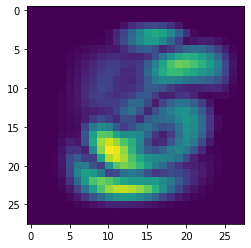

In [554]:
plt.imshow(reshaped_scores)

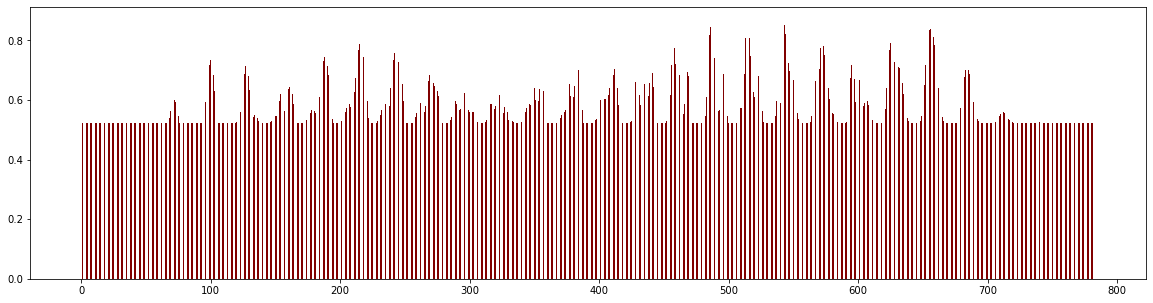

In [555]:
array_indexes = range(0, number_pixels)

fig = plt.figure(figsize = (20, 5))
plt.bar(array_indexes, scores, color ='maroon',
        width = 0.4)

plt.show()

#### Test Dataframe

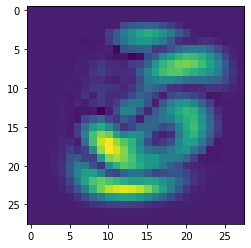

In [556]:
plt.imshow(reshaped_scores_test)

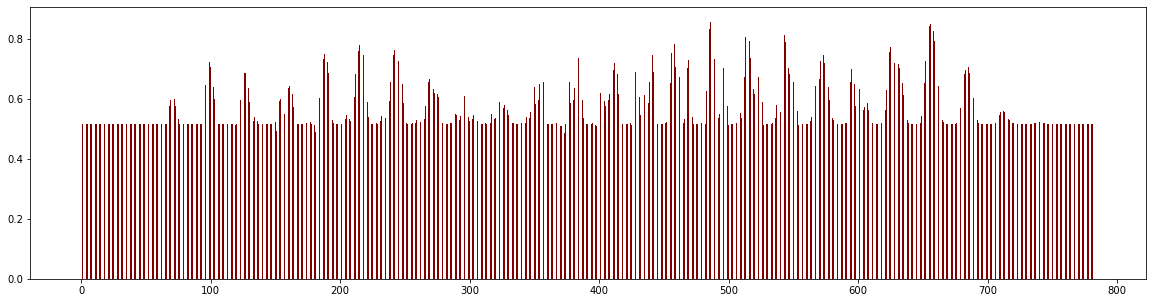

In [557]:
fig = plt.figure(figsize = (20, 5))
plt.bar(array_indexes, test_scores, color ='maroon',
        width = 0.4)

plt.show()

In [558]:
# The accuracy of the best pixel classifier for the test dataset 
max(test_scores)

0.8637837837837837

### Metrics for each image

In the previous section, we saw the metrics and heap map of accuracy for each of the pixels. 

Now, lets consider that the result for an image is the 
- Average of every classifer
- The best classifier

#### Average Classifier

In [559]:
## Training Predictions
preds_per_image_train = []

for img_idx in range(len_train):
    preds_for_img = []
    for pixel in range(number_pixels):
        preds_for_img.append(training_preds[pixel][img_idx])

    avg_pred = np.mean(preds_for_img)
    preds_per_image_train.append(avg_pred)


In [560]:
final_train_pred = [1 if pred >= 0.5 else 0 for pred in preds_per_image_train]

In [561]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [562]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_crop_train , final_train_pred)
print(cf_matrix)

[[5918    0]
 [5421    0]]


<AxesSubplot:>

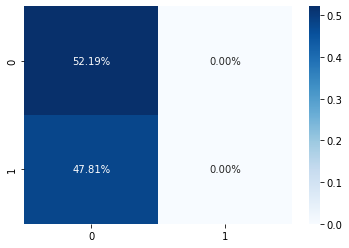

In [563]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

#### Best Classifier

Using the best pixel classifier as image classifier

In [564]:
index_max = np.argmax(scores)

In [565]:
## The best pixel classifier is the one that uses info from pixel 367
print(index_max, int(index_max/img_size), index_max%img_size)
print(scores[index_max])

514 18 10
0.868330540612047


[[5282  636]
 [ 857 4564]]


<AxesSubplot:>

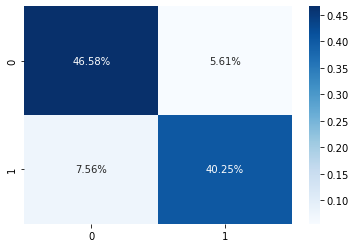

In [566]:
best_pixel_preds = [1 if x >=0.5 else 0 for x in training_preds[index_max]]
#Get the confusion matrix
cf_matrix = confusion_matrix(y_crop_train , best_pixel_preds)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

## Boosting

Now, lets use the classifiers for the boosting algorithm

In [567]:
for preds in test_preds:
    for p in preds:
        if p != 0 and p != 1:
            print(p)

In [609]:
# for this pixel, we have m = (number of pixels) experts


# Number of samples
N = len_test

# defining the weights array
w_t = [1] * N

# defining the probability array over the __data__
p_t = [1/N] * N

# defining gamma factor for gamma-weak learning
gamma = 0.1

# factor for learning
epsilon = 0.5

# tolerance for finding gamma-weak classifier
TOL = gamma*0.5

# defining the duration of the game
T = int(4*np.log(len_test)/gamma)


print(T)

300


In [610]:
# This function checks the gamma-weak of the classifier
# It does so by calculating the losses (pred != true) and multiplying by the distribution p^t
def check_gamma_weak(dist_p_t, clf_pred, true_y):
    sum = 0
    for idx in range(N):
        # this sum represents the ones that the classifier gets wrong
        sum += dist_p_t[idx]*(1 if clf_pred[idx] != true_y[idx] else 0)

    return sum

def creates_r_t(clf_pred, true_y):
    _r_t = [0]*N
    for idx in range(N):
        if clf_pred[idx] != true_y[idx]:
            _r_t[idx] = 1
    return _r_t


def multiplicative_weights_update(w_t, r_i):

    new_w_t = [0]*N

    for idx in range(N):
        new_w_t[idx] = w_t[idx]*(1 + epsilon*r_i[idx])

    return new_w_t

## Gets the most common element in a list
def most_common(lst):
    return max(set(lst), key=lst.count)


## Calculates the accuracy of the predictions from the boosting classifier
def boosting_accuracy(boosting_clfs, true_y):
    #predict_with_boosting
    predictions_boosting = []

    for elem in range(N):
        _preds = []
        for idx_clf in boosting_clfs:
            # the prediction from this classifier forr this element from the dataset
            _preds.append(test_preds[idx_clf][elem])
        
        predictions_boosting.append(most_common(_preds))

    test_score = accuracy_score(predictions_boosting, true_y)
    print(test_score)
    return test_score



In [611]:
boosted_classifier = []
boosting_accs = [0]
bossted_indexes = []

for t in range(T):
    
    gamma_weak_clf = None
    idx_gamma_weak_clf = -1

    # updates probabilities
    p_t = [w_t_i/sum(w_t) for w_t_i in w_t]

    best_clf_gamma = 1

    # find classifier c^t that is a weak learner for distribution p^t
    for clf_index, clf in enumerate(weak_classifiers):
        clf_gamma = check_gamma_weak(p_t, test_preds[clf_index], y_crop_test)
        # checks the classifier for gamma-weak
        if clf_gamma <= 0.5 - gamma and best_clf_gamma > clf_gamma:
            gamma_weak_clf = clf_gamma
            idx_gamma_weak_clf = clf_index
            best_clf_gamma = clf_gamma
            # break

    # checks if there are no gamma-weak classifers found
    if gamma_weak_clf == None:
        print("No more gamma-weak classifier for p^t distribution at iter ", t)
        break

    # defines reward array, r_i = 1 if classifier misses this sample, else r_i = 0
    r_t = creates_r_t(test_preds[idx_gamma_weak_clf], y_crop_test)

    # updates weights
    w_t = multiplicative_weights_update(w_t, r_t)

    # adds this classifier to the composed boosting classifier
    boosted_classifier.append(idx_gamma_weak_clf)
    bossted_indexes.append(idx_gamma_weak_clf)
    
    acc = boosting_accuracy(boosted_classifier, y_crop_test)
    boosting_accs.append(acc)

print("End of time T")

0.8637837837837837
0.8291891891891892
0.8945945945945946
0.847027027027027
0.9075675675675675
0.9064864864864864
0.9254054054054054
0.927027027027027
0.9313513513513514
0.9308108108108109
0.9335135135135135
0.9345945945945946
0.9394594594594594
0.94
0.9491891891891892
0.9508108108108108
0.9491891891891892
0.9513513513513514
0.9556756756756757
0.9540540540540541
0.9562162162162162
0.9551351351351351
0.9556756756756757
0.9578378378378378
0.9578378378378378
0.9583783783783784
0.9621621621621622
0.9616216216216216
0.9605405405405405
0.96
0.9621621621621622
No more gamma-weak classifier for p^t distribution at iter  31
End of time T


In [613]:
len(boosted_classifier)

31

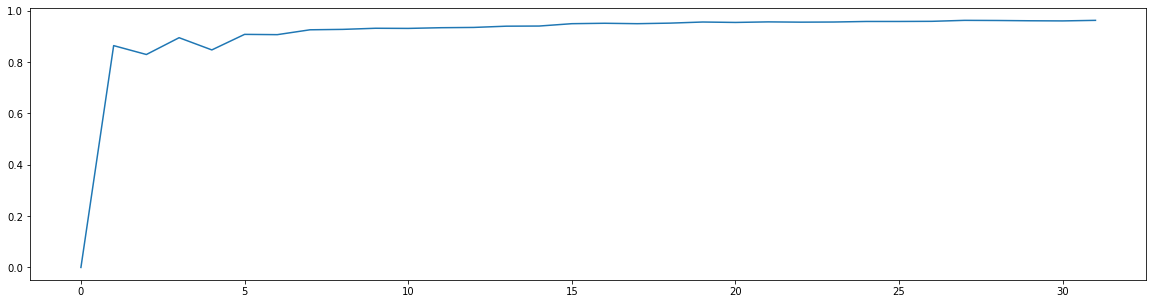

In [614]:
# Ploting the accuracy of the generated model for each iteration
fig = plt.figure(figsize = (20, 5))
plt.plot(boosting_accs)

In [615]:
acc_each_clf = []
for idx_clf in boosted_classifier:
    pred_weak_clf = accuracy_score(test_preds[idx_clf], y_crop_test)
    acc_each_clf.append(pred_weak_clf)
print(max(acc_each_clf))

0.8637837837837837


In [616]:
# Checking number of unique classifers chosen by Boosting
np.unique(bossted_indexes, return_counts=True)

(array([ 69,  99, 129, 190, 207, 215, 243, 244, 296, 350, 386, 415, 441,
        457, 459, 461, 484, 485, 486, 487, 514, 515, 548, 576, 577, 656,
        658, 660]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1]))

92